In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_circles, make_s_curve
from umap import UMAP
import torch
import matplotlib.pyplot as plt
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")

import sys
sys.path.append("..")
from dpa.dpa_fit import MDDPA

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.datasets import fetch_openml
mn = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
X_full = mn.data.astype(np.float32) / 255.0
y_full = mn.target.astype(int)
print("Loaded MNIST from openml:", X_full.shape)


# 2) Subsample up to 5,000 observations
n_sub = min(1000, X_full.shape[0])
rng = np.random.RandomState(42)
idx = rng.choice(X_full.shape[0], size=n_sub, replace=False)
X_sub = X_full[idx]
y_sub = y_full[idx]

# 3) Split into train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, test_size=0.3, random_state=42
)


Loaded MNIST from openml: (70000, 784)


In [3]:
X_train.shape, X_test.shape

((700, 784), (300, 784))

In [4]:
# 3. Fit methods
latent_dim = 2
pca = PCA(n_components=latent_dim).fit(X_train)
kpca = KernelPCA(n_components=latent_dim, kernel='rbf', fit_inverse_transform=True).fit(X_train)
umap_model = UMAP(n_components=latent_dim, random_state=42).fit(X_train)

# 4. Compute embeddings and direct inversions
X_test_pca = pca.transform(X_test)
X_test_pca_inv = pca.inverse_transform(X_test_pca)

X_test_kpca = kpca.transform(X_test)
X_test_kpca_inv = kpca.inverse_transform(X_test_kpca)

X_test_umap = umap_model.transform(X_test)
X_test_umap_inv = umap_model.inverse_transform(X_test_umap)

# 7. Fit distillers and compute MSE
errors = {
    'PCA (direct inverse)':       mean_squared_error(X_test, X_test_pca_inv),
    'KernelPCA (direct inverse)': mean_squared_error(X_test, X_test_kpca_inv),
    'UMAP (direct inverse)':      mean_squared_error(X_test, X_test_umap_inv),
}

distillers = {
    'PCA + MDDPA':       pca.transform(X_train),
    'KernelPCA + MDDPA': kpca.transform(X_train),
    'UMAP + MDDPA':      umap_model.transform(X_train),
}


/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


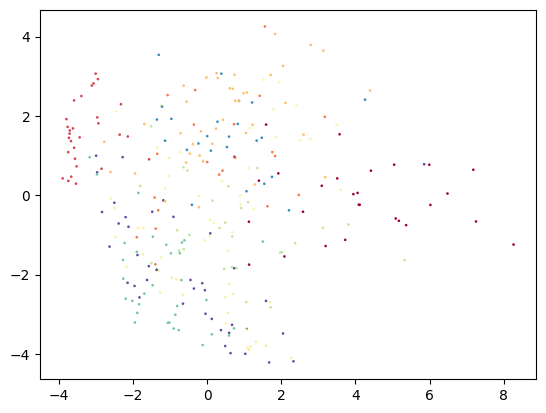

In [5]:
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, label='PCA', cmap='Spectral', s= 0.8)

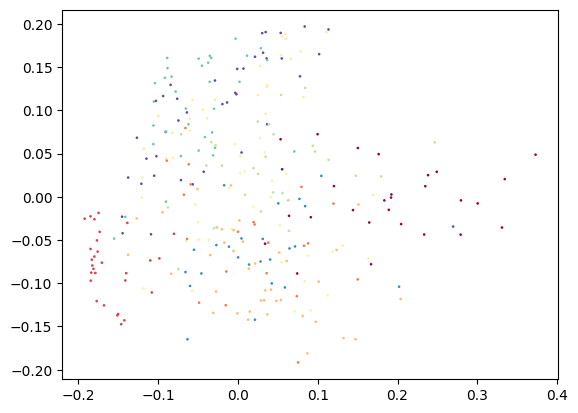

In [6]:
plt.scatter(X_test_kpca[:, 0], X_test_kpca[:, 1], c=y_test, label='PCA', cmap='Spectral', s= 0.8)

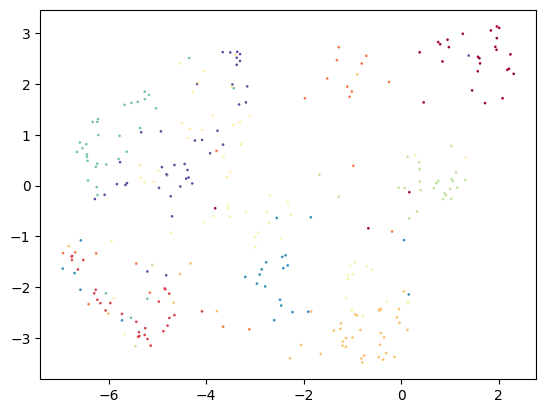

In [7]:
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test, label='PCA', cmap='Spectral', s= 0.8)

In [ ]:
for name, emb_train in distillers.items():
    dist = MDDPA(data_dim = X_sub.shape[1], num_layer=4, latent_dims = list(np.arange(latent_dim+2, -1, -1)), device=device)
    dist.train(x=torch.Tensor(X_train, device=device), z=torch.Tensor(emb_train, device=device), batch_size = 250, num_epochs=500)
    X_rec = dist.reconstruct(torch.Tensor(X_test).to(device), k=latent_dim, mean=True).cpu().detach().numpy()
    errors[name] = mean_squared_error(X_test, X_rec)

# 8. Create results table
results = pd.DataFrame([
    {'Method': m, 'Reconstruction MSE': mse}
    for m, mse in errors.items()
])

# Display to user
results

Running on CPU.

Start training with 3 batches each of size 250.

[Epoch 1] 7.6000, 7.7322, 7.7922, 7.8771, 7.9402
 pred 	16.4257, 16.7640, 16.9459, 17.3080, 17.5797
 var 	17.6515, 18.0636, 18.3072, 18.8618, 19.2790

[Epoch 100] 4.9061, 4.9061, 4.9556, 5.0527, 5.2921
 pred 	11.2731, 11.3894, 11.5787, 11.7427, 11.8925
 var 	12.7340, 12.9666, 13.2462, 13.3798, 13.2008

[Epoch 200] 4.6261, 4.6418, 4.6317, 4.8355, 5.1464
 pred 	9.6368, 9.7740, 9.8683, 10.1243, 10.3807
 var 	10.0213, 10.2643, 10.4731, 10.5776, 10.4687

[Epoch 300] 4.5519, 4.5512, 4.6069, 4.8654, 5.1756
 pred 	9.1769, 9.2808, 9.4556, 9.7756, 10.0815
 var 	9.2500, 9.4590, 9.6975, 9.8205, 9.8118

[Epoch 400] 4.4441, 4.4360, 4.5475, 4.7680, 5.1338
 pred 	8.9248, 9.0266, 9.3168, 9.6102, 9.9596
 var 	8.9615, 9.1813, 9.5386, 9.6845, 9.6514

[Epoch 500] 4.4525, 4.4472, 4.5569, 4.8329, 5.1469
 pred 	8.8392, 8.9461, 9.3269, 9.6096, 10.0087
 var 	8.7734, 8.9978, 9.5398, 9.5534, 9.7236

Running on CPU.

Start training with 3 batches ea

,Method,Reconstruction MSE
0,PCA (direct inverse),0.057344
1,KernelPCA (direct inverse),0.068366
2,UMAP (direct inverse),0.077644
3,PCA + MDDPA,0.055216
4,KernelPCA + MDDPA,0.065606
5,UMAP + MDDPA,0.055613


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_pca = LogisticRegression(random_state=0).fit(pca.transform(X_train), y_train)
log_kpca = LogisticRegression(random_state=0).fit(kpca.transform(X_train), y_train)
log_umap = LogisticRegression(random_state=0).fit(umap_model.transform(X_train), y_train)

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
accuracy_score(log_pca.predict(pca.transform(X_train)), y_train), \
accuracy_score(log_kpca.predict(kpca.transform(X_train)), y_train), \
accuracy_score(log_umap.predict(umap_model.transform(X_train)), y_train)

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(0.43142857142857144, 0.3342857142857143, 0.6785714285714286)

In [11]:
accuracy_score(log_pca.predict(pca.transform(X_test)), y_test), \
accuracy_score(log_kpca.predict(kpca.transform(X_test)), y_test), \
accuracy_score(log_umap.predict(umap_model.transform(X_test)), y_test)

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(0.44, 0.4033333333333333, 0.6333333333333333)